## Model Load

In [2]:
import os, sys, time, logging, configparser
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))
sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")

from XAE.dataset import rmMNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import import_module
from random import sample

In [19]:
from model.sswae_gan import SSWAE_GAN_MNIST as cur_model

In [28]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/train_config_sswae_gan8.cfg')

['./config/train_config_sswae_gan3-1-8.cfg']

In [29]:
mm = cur_model(cfg, log, device = device, verbose=0)
mm.load(cfg['path_info']['save_path'])

In [30]:
batch_size = 100
test_data = rmMNIST(cfg['path_info']['data_home2'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [31]:
test_iter = iter(test_generator)
encoded_label = np.zeros((n*batch_size, 2))
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()
    encoded_label[(i*batch_size):((i+1)*batch_size),:] = mm.encode_s(img.to(device))[:,0:2].to('cpu').detach().numpy()
    
labeled_class = cfg['train_info']['labeled_class'].replace(' ', '').split(',')
labeled_class = [int(i) for i in labeled_class]
test_class = cfg['train_info']['test_class'].replace(' ', '').split(',')
test_class = [int(i) for i in test_class]

## Label space(z_2) plot

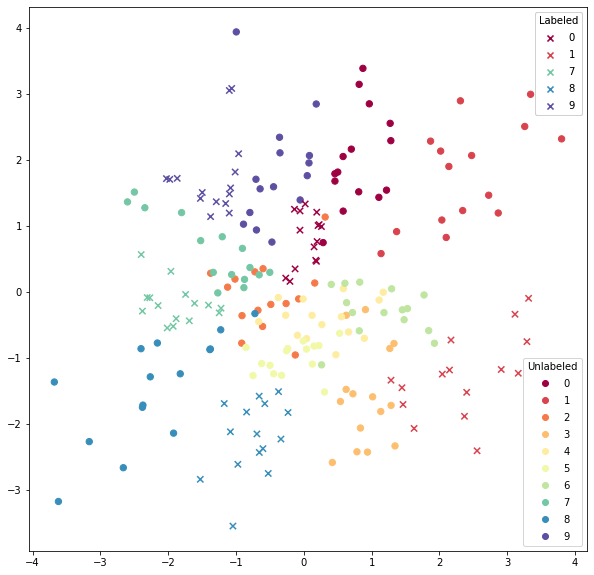

In [32]:
nn = 15
xx = []
yy = []
fig, ax = plt.subplots(figsize = (10.0, 10.0))
for i in range(10):
    target_d = encoded_label[true_label == i,:]
    target = target_d[np.random.choice(target_d.shape[0], nn, replace = False),:]
    xx.append(target[:,0])
    yy.append(target[:,1])
scatter1 = ax.scatter(np.concatenate(xx), np.concatenate(yy), c = np.repeat([int(i) for i in range(10)], nn), s = 40.0, cmap = 'Spectral')
dd = mm.enc_c(torch.Tensor(np.eye(len(labeled_class)).repeat(nn, axis = 0)).to(device)).to('cpu').detach().numpy()
scatter2 = ax.scatter(dd[:,0], dd[:,1], c = np.repeat(labeled_class, nn), s = 40.0, marker = 'x', cmap = 'Spectral')

legend1 = ax.legend(*scatter1.legend_elements(), loc = 'lower right', title = "Unlabeled")
legend2 = ax.legend(*scatter2.legend_elements(), loc = 'upper right', title = "Labeled")
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.show()

## Test class Reconstruction

In [33]:
target_d = torch.tensor(list(range(true_label.shape[0])))[true_label == 2]
z = mm.encode_s(torch.cat([test_data[i][0] for i in target_d[0:16]]).unsqueeze(1).to(device))
recon = mm.decode(z)

In [34]:
sample_data = []
target_d = np.array(range(len(test_data)))[true_label == test_class[0]]

for j in range(2):
    sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target_d[(8*j):(8*(j+1))]], axis = 1))
for j in range(2):
    sample_data.append(np.concatenate([recon[i,0,:,:].detach().to('cpu').numpy() for i in range(8*j, 8*(j+1))], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)

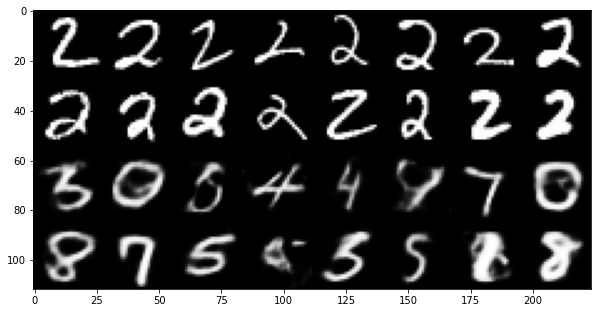

In [35]:
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

In [36]:
sample_label = []
for i in range(10):
    target_d = np.array(range(len(test_data)))[true_label == i]
    sample_label.append(target_d[np.random.choice(target_d.shape[0], 1, replace = False)[0]])
sample_data = np.array([test_data[i][0].numpy()[0,:,:] for i in sample_label])
z = mm.encode_s(torch.Tensor(sample_data).unsqueeze(1).to(device))
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

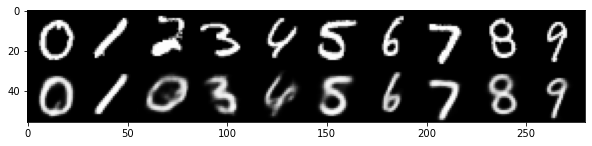

In [37]:
img_data = np.concatenate([np.concatenate(sample_data, axis = 1), np.concatenate(recon, axis = 1)], axis = 0)
fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

## 1. One-shot Exemplar Generation

In [38]:
exn = 5

In [39]:
zz = torch.cat((torch.zeros(1,6), gaus(exn,6)), dim = 0).to(device)
new_z = torch.cat((z[:,:2].repeat_interleave(exn + 1, dim = 0), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

In [40]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([sample_data[i]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

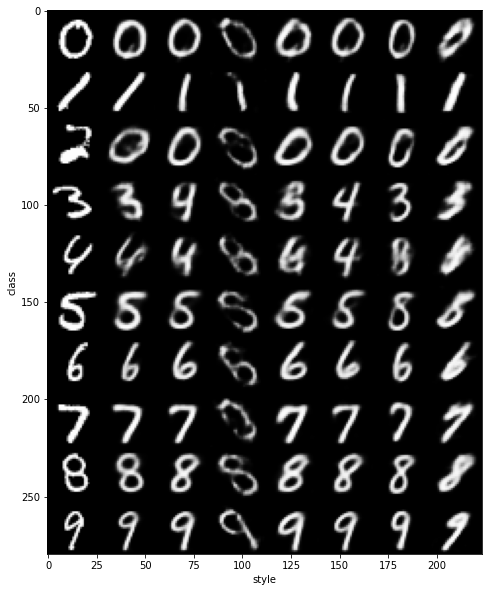

In [41]:
fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [42]:
new_z = torch.cat((z[:,:2].repeat_interleave(10, dim = 0), z[:,2:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

In [43]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate(sample_data, axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = sample_data[i,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

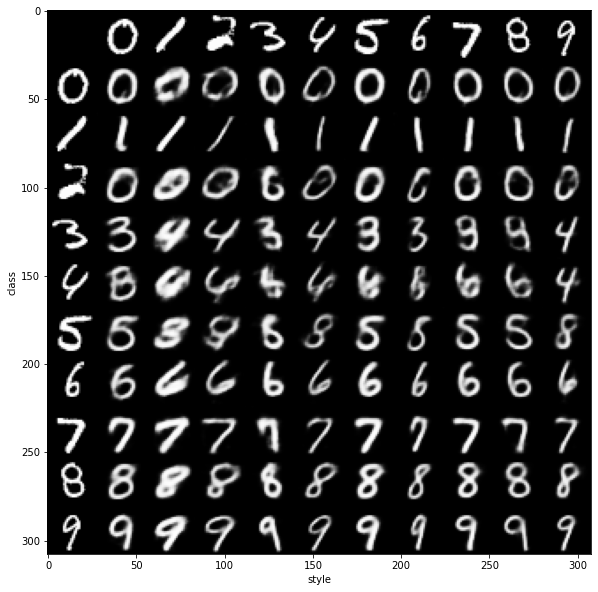

In [44]:
fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()